In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

df = (
    pd.concat([load_sweep("RMOE-78-long-context-v3")]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["model", "confusion_contexts", "name", "k", "rank", "transfers", "prefill_length", "score", "score_stderr"]]
)
df.head()

,model,confusion_contexts,name,k,rank,transfers,prefill_length,score,score_stderr
0,vicuna-7b-v1.5-16k,63,ann,1523.0,32.0,7.992482e+08,12187.118,0.530,0.015783
1,vicuna-7b-v1.5-16k,63,eviction,3046.0,NaN,8.237130e+08,12187.118,0.387,0.015402
2,vicuna-7b-v1.5-16k,63,dense,NaN,NaN,3.195042e+09,12187.118,0.563,0.015685
3,vicuna-7b-v1.5-16k,3,ann,103.0,32.0,5.487398e+07,830.621,0.465,0.015773
4,vicuna-7b-v1.5-16k,3,eviction,207.0,NaN,5.622809e+07,830.621,0.377,0.015326


In [8]:
df.pivot_table(index="confusion_contexts", columns="name", values="score")

name,ann,dense,eviction
confusion_contexts,,,
3,0.465,0.673,0.377
7,0.658,0.674,0.343
15,0.551,0.655,0.425
31,0.625,0.641,0.485
63,0.530,0.563,0.387


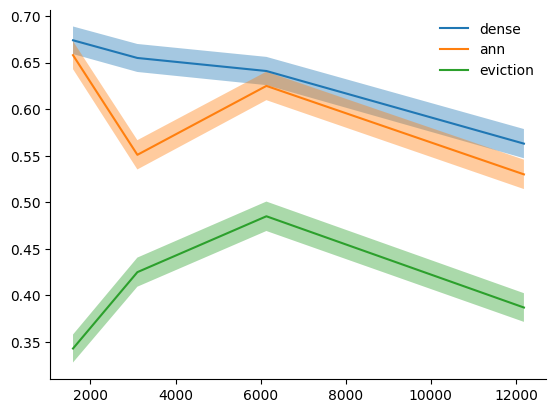

In [11]:
ax = plt.gca()
for name in ["dense", "ann", "eviction"]:
    g = df[(df["name"] == name) & (df["confusion_contexts"] >= 7)].sort_values("prefill_length")
    ax.plot(g.prefill_length, g.score, label=name)
    ax.fill_between(g.prefill_length, g.score - g.score_stderr, g.score + g.score_stderr,
                    alpha=.4)
ax.legend(frameon=False)
sns.despine(ax=ax)